In [1]:
!nvidia-smi

Tue Sep  3 13:52:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:01:00.0 Off |                  Off |
| 61%   84C    P2             296W / 300W |  27002MiB / 49140MiB |     96%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!gpustat

Error on querying NVIDIA devices. Use --debug flag to see more details.
[Errno 0] Error


In [3]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Load the data

In [4]:
# File paths
gpt_crows_results_dir = '../results/crows_Dropout/crows_m-DropoutGPT2LMHeadModel_c-gpt2.json'
gpt_stereoset_results_dir = '../results/stereoset_Dropout_processed/gpt2'
gpt_before_debias_crows_results_dir = '../results/crows/crows_m-GPT2LMHeadModel_c-gpt2.json'
gpt_before_debias_stereoset_results_dir = '../results/stereoset_processed/stereoset_m-GPT2LMHeadModel_c-gpt2_s-42.json'
gpt_training_output_dir = '../results/dropout_FT/gpt2'

In [5]:
# Load data into dicts
import json

# Load trainer_state.json
with open(f'{gpt_training_output_dir}/trainer_state.json', 'r') as f:
    gpt2_train_state = json.load(f)
# Exclude last entry because it is the final train results
gpt2_train_state = gpt2_train_state["log_history"][:-1]

# Load stereoset data (Before)
with open(f'{gpt_before_debias_stereoset_results_dir}', 'r') as f:
    gpt2_stereoset_results_before = json.load(f)
# Go into first key for before stereoset data
gpt2_stereoset_results_before = gpt2_stereoset_results_before[list(gpt2_stereoset_results_before.keys())[0]]['intrasentence']
    
# Load crows data (Before)
with open(f'{gpt_before_debias_crows_results_dir}', 'r') as f:
    gpt2_crows_results_before = json.load(f)
    
# Load stereoset data (After)
with open(f'{gpt_stereoset_results_dir}/combined.json', 'r') as f:
    gpt2_stereoset_results_after = json.load(f)
    
# Load crows data (After)
with open(gpt_crows_results_dir, 'r') as f:
    gpt2_crows_results_after = json.load(f)

# Visualize the data (GPT2)

## Training step vs crows benchmark

In [6]:
# Set data
steps = [d['step'] for d in gpt2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in gpt2_crows_results_after.items():
    gender_scores[key] = value['gender']['Stereotype score']
    race_scores[key] = value['race-color']['Stereotype score']
    religion_scores[key] = value['religion']['Stereotype score']

# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
crows_before_debias_ss_gender = gpt2_crows_results_before['gender']['Stereotype score']
crows_before_debias_ss_race = gpt2_crows_results_before['race-color']['Stereotype score']
crows_before_debias_ss_religion = gpt2_crows_results_before['religion']['Stereotype score']

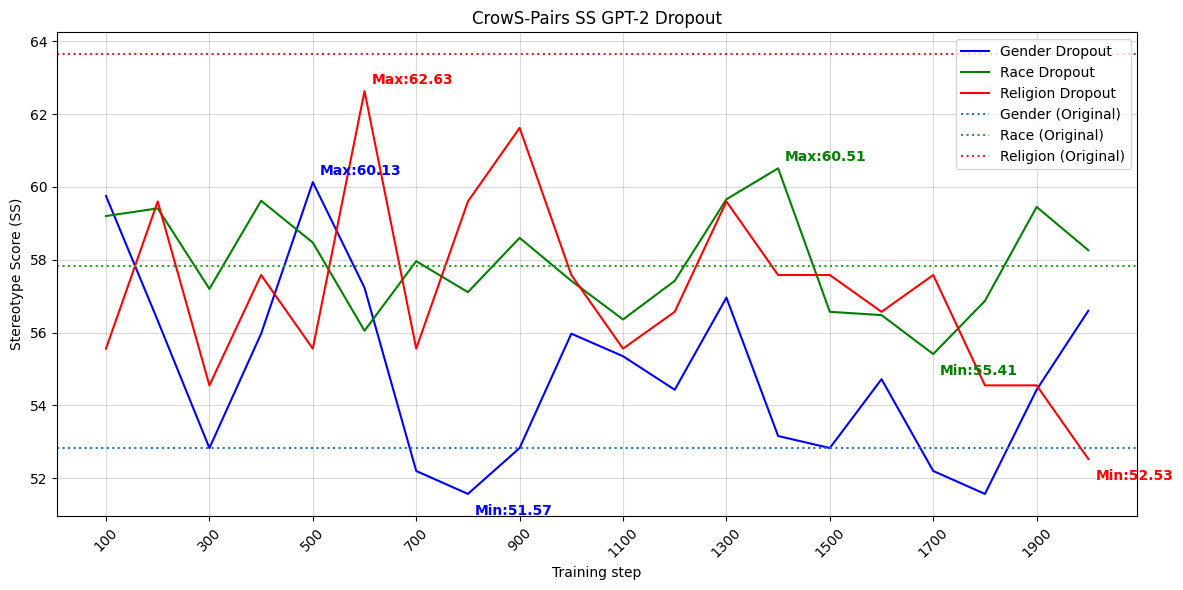

In [7]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')

# Add grid
plt.grid(True, alpha=0.3, color='grey')

# Set black frame for axes
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Training step')
ax.set_ylabel('Stereotype Score (SS)')
ax.set_title('CrowS-Pairs SS GPT-2 Dropout')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=crows_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=crows_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=crows_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/gpt2_dropout_crows.png')

# Training step vs stereoset benchmark

In [8]:
# Set data
steps = [d['step'] for d in gpt2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in gpt2_stereoset_results_after.items():
    gender_scores[key] = value['intrasentence']['gender']['SS Score']
    race_scores[key] = value['intrasentence']['race']['SS Score']
    religion_scores[key] = value['intrasentence']['religion']['SS Score']
    
# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
stereoset_before_debias_ss_gender = gpt2_stereoset_results_before['gender']['SS Score']
stereoset_before_debias_ss_race = gpt2_stereoset_results_before['race']['SS Score']
stereoset_before_debias_ss_religion = gpt2_stereoset_results_before['religion']['SS Score']

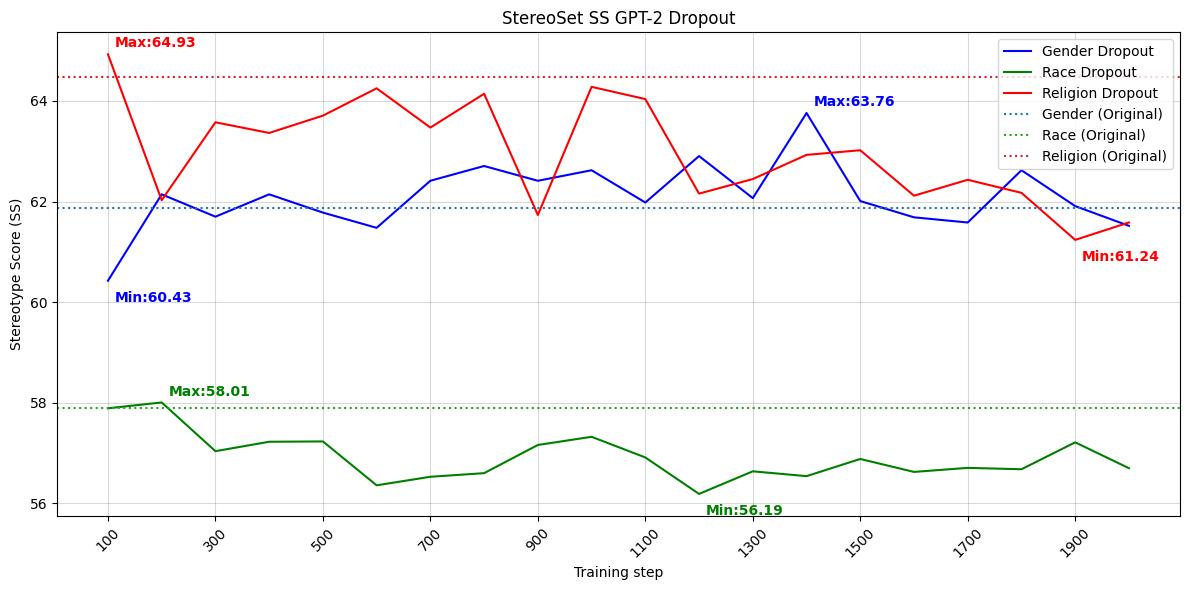

In [9]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')

# Add grid
plt.grid(True, alpha=0.3, color='grey')

# Set black frame for axes
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Training step')
ax.set_ylabel('Stereotype Score (SS)')
ax.set_title('StereoSet SS GPT-2 Dropout')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=stereoset_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=stereoset_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=stereoset_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/gpt2_dropout_stereoset.png')

# Loss vs step

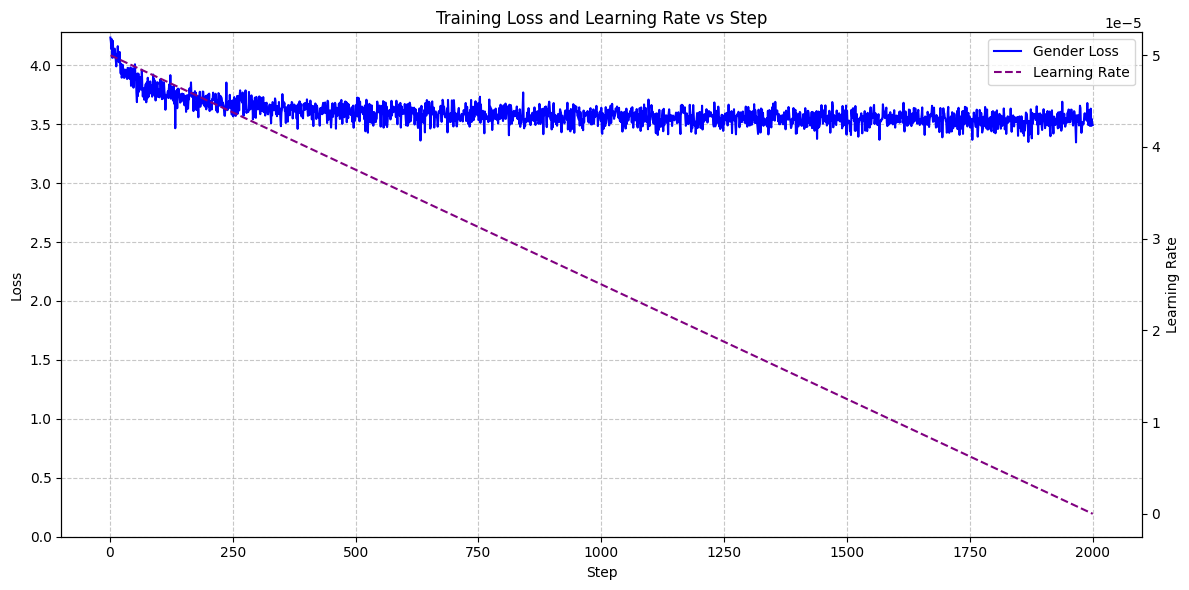

In [10]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot training loss vs step
# Left axis: loss
# Bottom axis: Step

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract key values from training data
steps = [d['step'] for d in gpt2_train_state]
loss = [d['loss'] for d in gpt2_train_state]
learning_rate = [d['learning_rate'] for d in gpt2_train_state]


# Plot loss vs step on the primary y-axis
ax1.plot(steps, loss, label='Gender Loss', color='blue')

# Set labels and title for the primary y-axis
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss and Learning Rate vs Step')

# Adjust y-axis to start from 0
ax1.set_ylim(bottom=0)

# Create a secondary y-axis for learning rate
ax2 = ax1.twinx()
ax2.plot(steps, learning_rate, label='Learning Rate', color='purple', linestyle='--')
ax2.set_ylabel('Learning Rate')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/gpt2_dropout_loss_step.png')

# Phi 2

In [11]:
# File paths
phi_crows_results_dir = '../results/crows_Dropout/crows_m-DropoutPhi2LMHeadModel_c-microsoft_phi-2.json'
phi_stereoset_results_dir = '../results/stereoset_Dropout_processed/phi2'
phi_before_debias_crows_results_dir = '../results/crows/crows_m-PhiForCausalLM_c-microsoft_phi-2.json'
phi_before_debias_stereoset_results_dir = '../results/stereoset_processed/stereoset_m-PhiForCausalLM_c-microsoft_phi-2_s-42.json'
phi_training_output_dir = '../results/dropout_FT/phi2'

In [12]:
# Load data into dicts
import json

# Load trainer_state.json
with open(f'{phi_training_output_dir}/trainer_state.json', 'r') as f:
    phi2_train_state = json.load(f)
# Exclude last entry because it is the final train results
phi2_train_state = phi2_train_state["log_history"][:-1]

# Load stereoset data (Before)
with open(f'{phi_before_debias_stereoset_results_dir}', 'r') as f:
    phi2_stereoset_results_before = json.load(f)
# Go into first key for before stereoset data
phi2_stereoset_results_before = phi2_stereoset_results_before[list(phi2_stereoset_results_before.keys())[0]]['intrasentence']
    
# Load crows data (Before)
with open(f'{phi_before_debias_crows_results_dir}', 'r') as f:
    phi2_crows_results_before = json.load(f)
    
# Load stereoset data (After)
with open(f'{phi_stereoset_results_dir}/combined.json', 'r') as f:
    phi2_stereoset_results_after = json.load(f)
    
# Load crows data (After)
with open(phi_crows_results_dir, 'r') as f:
    phi2_crows_results_after = json.load(f)

# Training step vs crows benchmark

In [13]:
# Set data
steps = [d['step'] for d in phi2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in phi2_crows_results_after.items():
    gender_scores[key] = value['gender']['Stereotype score']
    race_scores[key] = value['race-color']['Stereotype score']
    religion_scores[key] = value['religion']['Stereotype score']

# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
crows_before_debias_ss_gender = phi2_crows_results_before['gender']['Stereotype score']
crows_before_debias_ss_race = phi2_crows_results_before['race-color']['Stereotype score']
crows_before_debias_ss_religion = phi2_crows_results_before['religion']['Stereotype score']

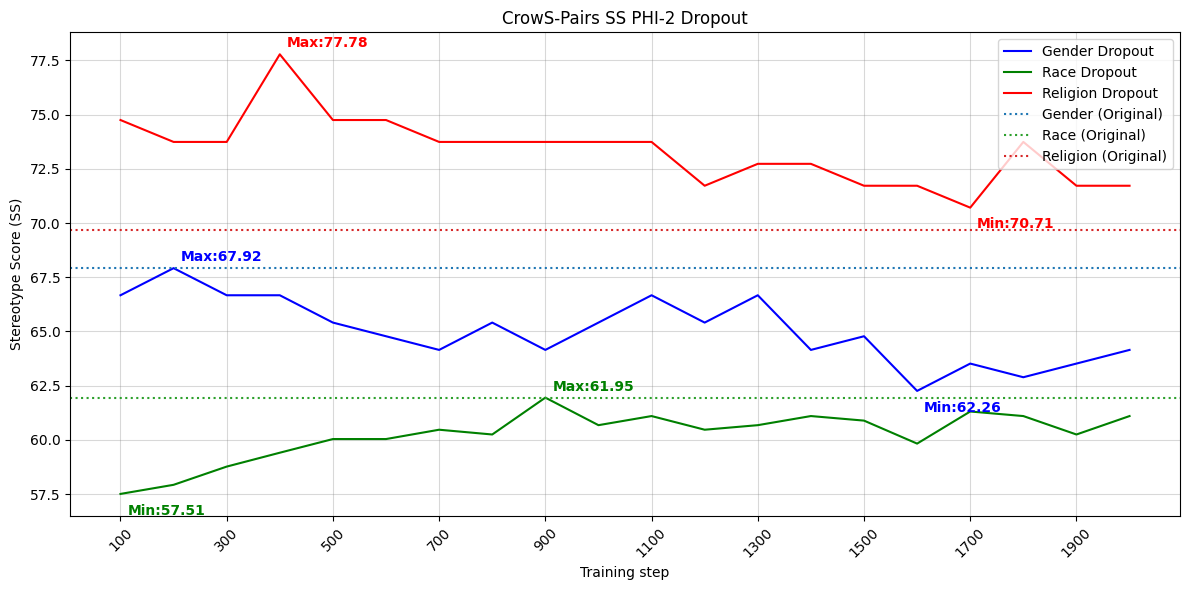

In [14]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')

# Add grid
plt.grid(True, alpha=0.3, color='grey')

# Set black frame for axes
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Training step')
ax.set_ylabel('Stereotype Score (SS)')
ax.set_title('CrowS-Pairs SS PHI-2 Dropout')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=crows_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=crows_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=crows_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/phi2_dropout_crows.png')

# Training step vs stereoset benchmark

In [15]:
# Set data
steps = [d['step'] for d in phi2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in phi2_stereoset_results_after.items():
    gender_scores[key] = value['intrasentence']['gender']['SS Score']
    race_scores[key] = value['intrasentence']['race']['SS Score']
    religion_scores[key] = value['intrasentence']['religion']['SS Score']
    
# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
stereoset_before_debias_ss_gender = phi2_stereoset_results_before['gender']['SS Score']
stereoset_before_debias_ss_race = phi2_stereoset_results_before['race']['SS Score']
stereoset_before_debias_ss_religion = phi2_stereoset_results_before['religion']['SS Score']

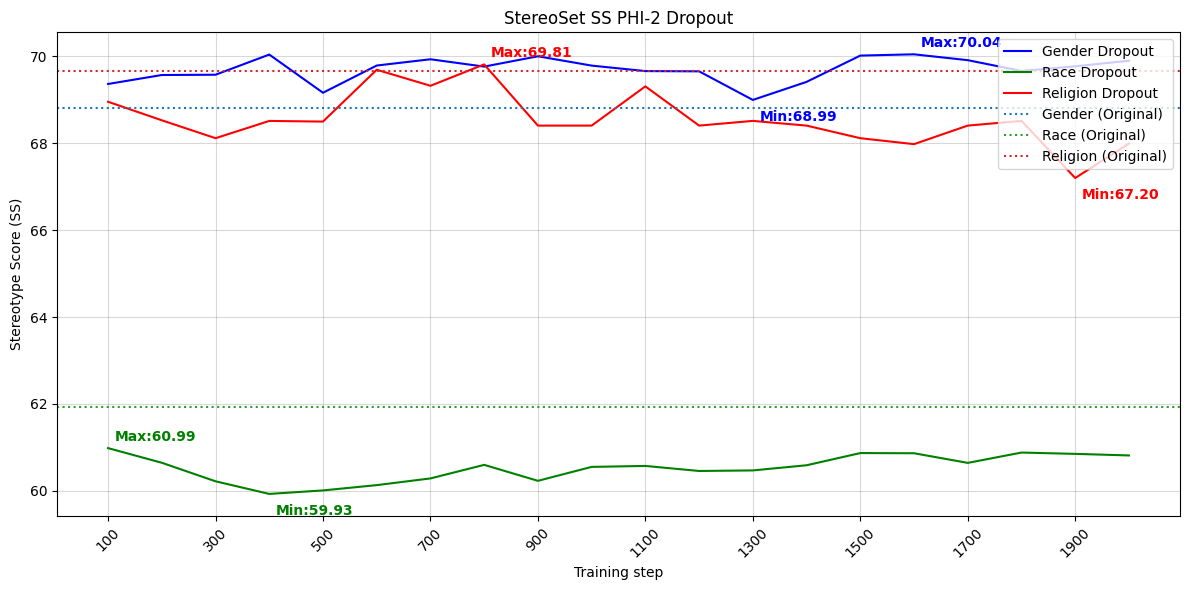

In [16]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')

# Add grid
plt.grid(True, alpha=0.3, color='grey')

# Set black frame for axes
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Training step')
ax.set_ylabel('Stereotype Score (SS)')
ax.set_title('StereoSet SS PHI-2 Dropout')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=stereoset_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=stereoset_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=stereoset_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/phi2_dropout_stereoset.png')

# Loss vs step

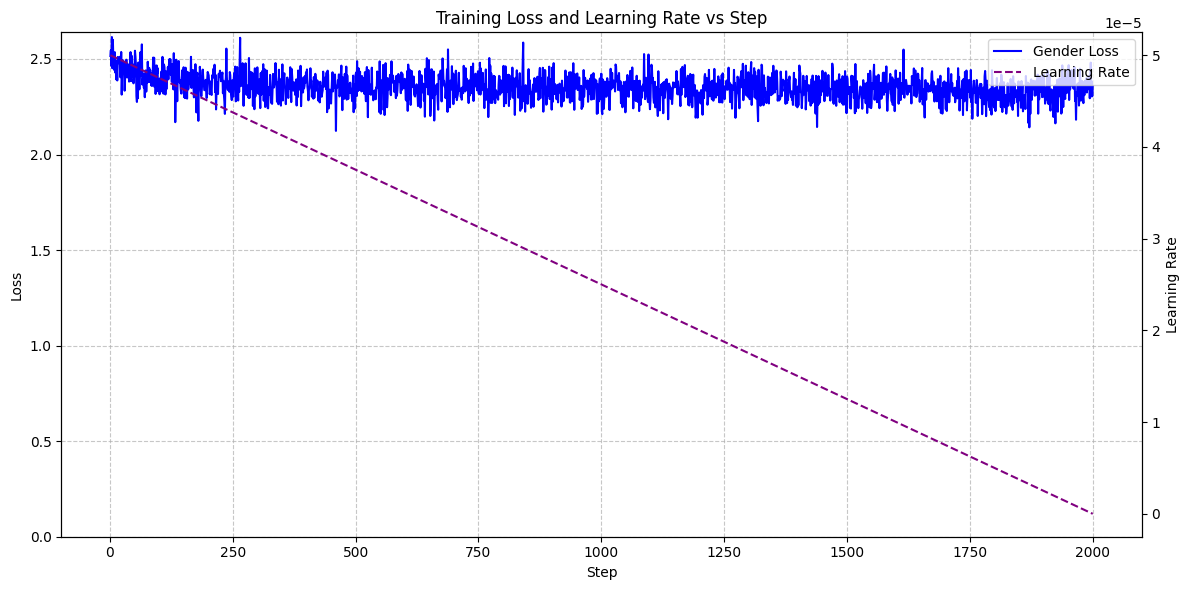

In [17]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot training loss vs step
# Left axis: loss
# Bottom axis: Step

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract key values from training data
steps = [d['step'] for d in phi2_train_state]
loss = [d['loss'] for d in phi2_train_state]
learning_rate = [d['learning_rate'] for d in phi2_train_state]


# Plot loss vs step on the primary y-axis
ax1.plot(steps, loss, label='Gender Loss', color='blue')

# Set labels and title for the primary y-axis
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss and Learning Rate vs Step')

# Adjust y-axis to start from 0
ax1.set_ylim(bottom=0)

# Create a secondary y-axis for learning rate
ax2 = ax1.twinx()
ax2.plot(steps, learning_rate, label='Learning Rate', color='purple', linestyle='--')
ax2.set_ylabel('Learning Rate')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/phi2_dropout_loss_step.png')

# Llama 2

In [18]:
# File paths
llama_crows_results_dir = '../results/crows_Dropout/crows_m-DropoutLlama2LMHeadModel_c-meta-llama_Llama-2-7b-hf.json'
llama_stereoset_results_dir = '../results/stereoset_Dropout_processed/llama2'
llama_before_debias_crows_results_dir = '../results/crows/crows_m-LlamaForCausalLM_c-meta-llama_Llama-2-7b-hf.json'
llama_before_debias_stereoset_results_dir = '../results/stereoset_processed/stereoset_m-LlamaForCausalLM_c-meta-llama_Llama-2-7b-hf_s-42.json'
llama_training_output_dir = '../results/dropout_FT/llama2'

In [19]:
# Load data into dicts
import json

# Load trainer_state.json
with open(f'{llama_training_output_dir}/trainer_state.json', 'r') as f:
    llama2_train_state = json.load(f)
# Exclude last entry because it is the final train results
llama2_train_state = llama2_train_state["log_history"][:-1]

# Load stereoset data (Before)
with open(f'{llama_before_debias_stereoset_results_dir}', 'r') as f:
    llama2_stereoset_results_before = json.load(f)
# Go into first key for before stereoset data
llama2_stereoset_results_before = llama2_stereoset_results_before[list(llama2_stereoset_results_before.keys())[0]]['intrasentence']
    
# Load crows data (Before)
with open(f'{llama_before_debias_crows_results_dir}', 'r') as f:
    llama2_crows_results_before = json.load(f)
    
# Load stereoset data (After)
with open(f'{llama_stereoset_results_dir}/combined.json', 'r') as f:
    llama2_stereoset_results_after = json.load(f)
    
# Load crows data (After)
with open(llama_crows_results_dir, 'r') as f:
    llama2_crows_results_after = json.load(f)

# Training step vs crows benchmark

In [20]:
# Set data
steps = [d['step'] for d in llama2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in llama2_crows_results_after.items():
    gender_scores[key] = value['gender']['Stereotype score']
    race_scores[key] = value['race-color']['Stereotype score']
    religion_scores[key] = value['religion']['Stereotype score']

# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
crows_before_debias_ss_gender = llama2_crows_results_before['gender']['Stereotype score']
crows_before_debias_ss_race = llama2_crows_results_before['race-color']['Stereotype score']
crows_before_debias_ss_religion = llama2_crows_results_before['religion']['Stereotype score']

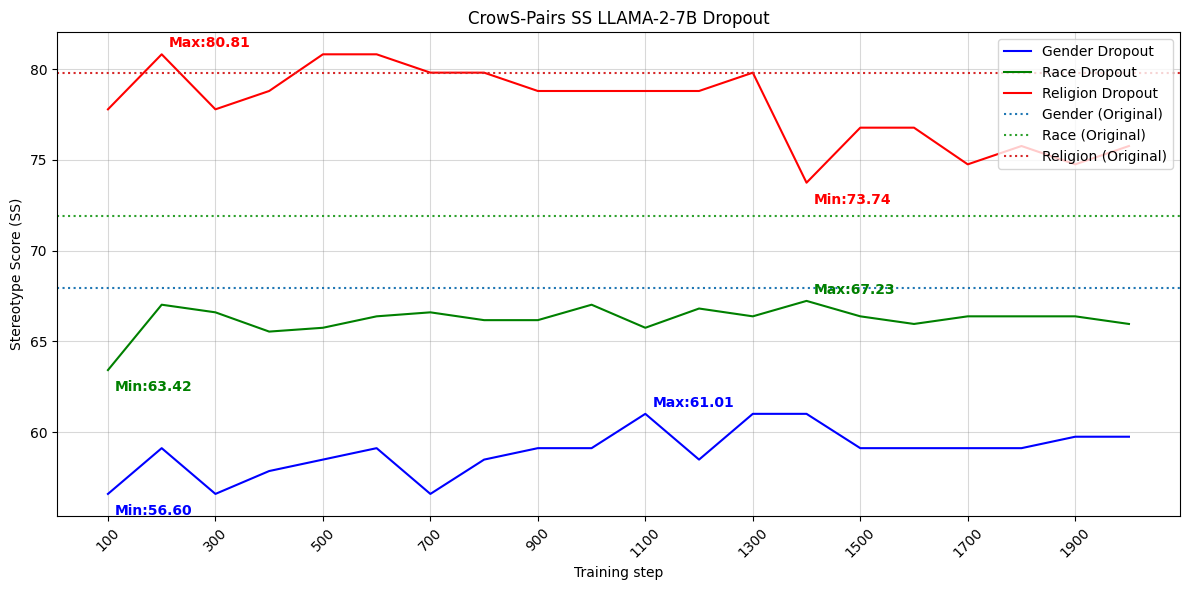

In [21]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')

# Add grid
plt.grid(True, alpha=0.3, color='grey')

# Set black frame for axes
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Training step')
ax.set_ylabel('Stereotype Score (SS)')
ax.set_title('CrowS-Pairs SS LLAMA-2-7B Dropout')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=crows_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=crows_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=crows_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/llama2_dropout_crows.png')

# Training step vs stereoset benchmark

In [22]:
# Set data
steps = [d['step'] for d in llama2_train_state]
gender_scores = {}
race_scores = {}
religion_scores = {}
# Extract gender stereotype scores
for key, value in llama2_stereoset_results_after.items():
    gender_scores[key] = value['intrasentence']['gender']['SS Score']
    race_scores[key] = value['intrasentence']['race']['SS Score']
    religion_scores[key] = value['intrasentence']['religion']['SS Score']
    
# Sort the steps and scores in step order
steps = sorted([int(step) for step in gender_scores.keys()])
gender_scores = [gender_scores[str(step)] for step in steps]
race_scores = [race_scores[str(step)] for step in steps]
religion_scores = [religion_scores[str(step)] for step in steps]

# Extract before debias stereoset benchmark data
stereoset_before_debias_ss_gender = llama2_stereoset_results_before['gender']['SS Score']
stereoset_before_debias_ss_race = llama2_stereoset_results_before['race']['SS Score']
stereoset_before_debias_ss_religion = llama2_stereoset_results_before['religion']['SS Score']

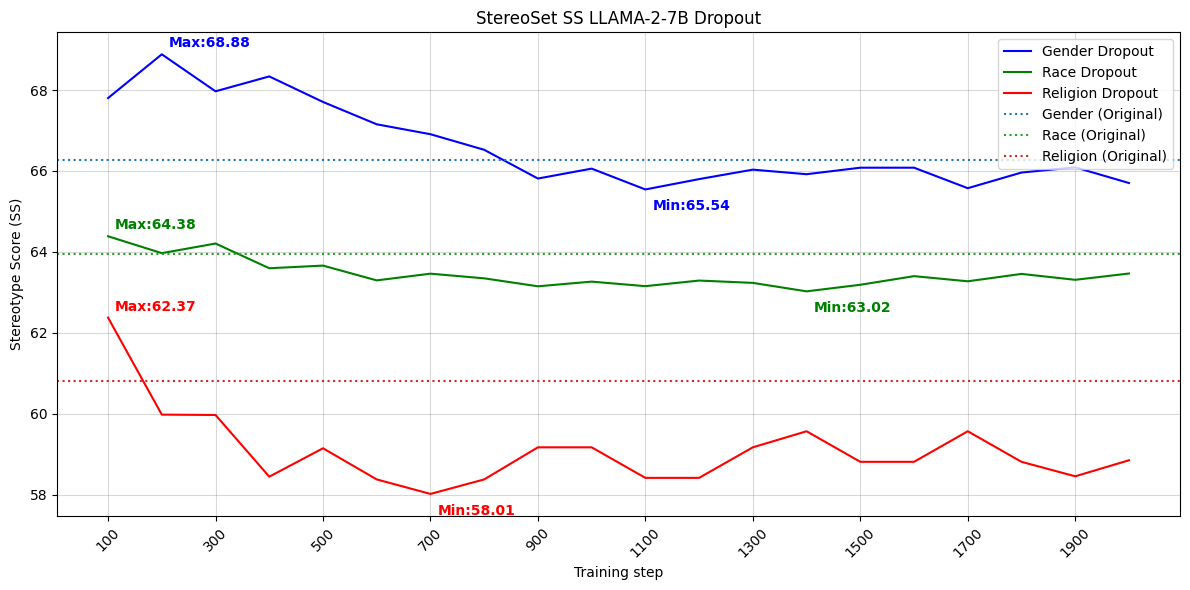

In [23]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot crows stereotype score vs step
# Left axis: crows stereotype score for 3 categories gender, race, religion
# Bottom axis: Step

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

fig.patch.set_facecolor('white')  # Set figure background to white
ax.set_facecolor('white')

# Add grid
plt.grid(True, alpha=0.3, color='grey')

# Set black frame for axes
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

# Function to plot a line and label its max and min points
def plot_line_with_labels(ax, x, y, color, label):
    line, = ax.plot(x, y, color=color, label=label)
    
    # Find max and min points
    max_index = np.argmax(y)
    min_index = np.argmin(y)
    
    # Label max point
    ax.annotate(f'Max:{y[max_index]:.2f}', 
                (x[max_index], y[max_index]),
                xytext=(5, 5), textcoords='offset points',
                color=color, fontweight='bold')
    
    # Label min point
    ax.annotate(f'Min:{y[min_index]:.2f}', 
                (x[min_index], y[min_index]),
                xytext=(5, -15), textcoords='offset points',
                color=color, fontweight='bold')
    
    return line

# Plot CROWS stereotype scores with labels
gender_line = plot_line_with_labels(ax, steps, gender_scores, 'blue', 'Gender Dropout')
race_line = plot_line_with_labels(ax, steps, race_scores, 'green', 'Race Dropout')
religion_line = plot_line_with_labels(ax, steps, religion_scores, 'red', 'Religion Dropout')

# Set labels and title
ax.set_xlabel('Training step')
ax.set_ylabel('Stereotype Score (SS)')
ax.set_title('StereoSet SS LLAMA-2-7B Dropout')

# Draw line for original stereotype score crows and add labels
ax.axhline(y=stereoset_before_debias_ss_gender, color='tab:blue', linestyle='dotted', label='Gender (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_gender, f' {stereoset_before_debias_ss_gender:.2f}', 
#         va='center', ha='left', color='tab:blue')

ax.axhline(y=stereoset_before_debias_ss_race, color='tab:green', linestyle='dotted', label='Race (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_race, f' {stereoset_before_debias_ss_race:.2f}', 
#         va='center', ha='left', color='tab:green')

ax.axhline(y=stereoset_before_debias_ss_religion, color='tab:red', linestyle='dotted', label='Religion (Original)')
# ax.text(ax.get_xlim()[1], stereoset_before_debias_ss_religion, f' {stereoset_before_debias_ss_religion:.2f}', 
#         va='center', ha='left', color='tab:red')

# Add legend
ax.legend(loc='upper right')

# Add grid
plt.grid(True, alpha=0.3)

# Adjust x-axis ticks
plt.xticks(steps[::2], rotation=45)  # Show every other step label, rotated 45 degrees

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/llama2_dropout_stereoset.png')

# Loss vs step

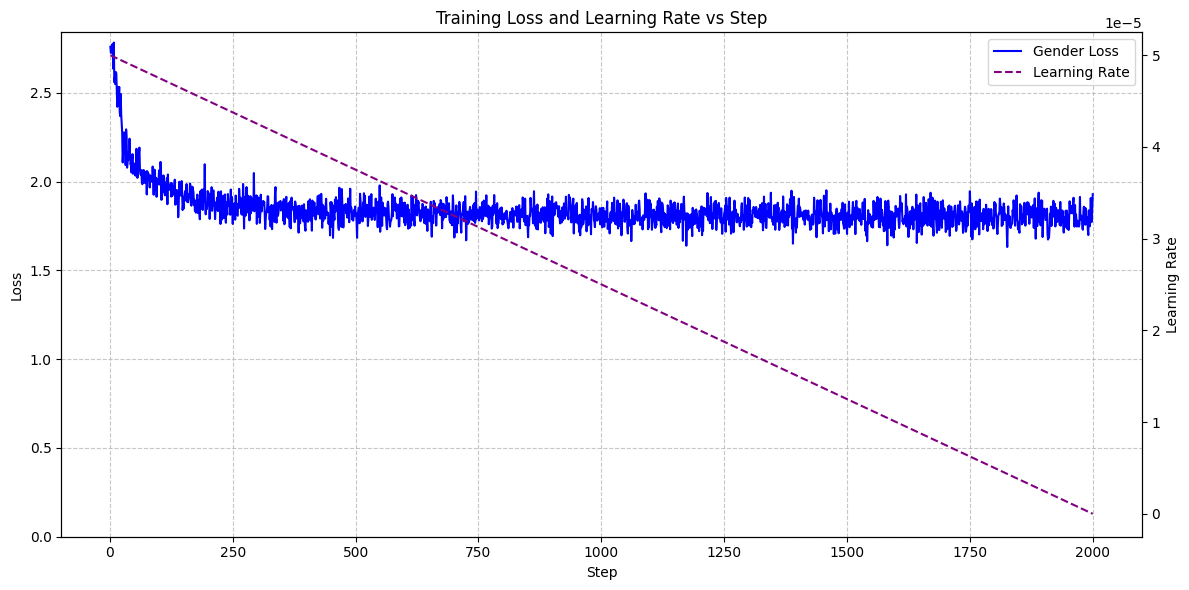

In [24]:
import matplotlib.pyplot as plt
import os
import numpy as np

# Plot training loss vs step
# Left axis: loss
# Bottom axis: Step

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Extract key values from training data
steps = [d['step'] for d in llama2_train_state]
loss = [d['loss'] for d in llama2_train_state]
learning_rate = [d['learning_rate'] for d in llama2_train_state]


# Plot loss vs step on the primary y-axis
ax1.plot(steps, loss, label='Gender Loss', color='blue')

# Set labels and title for the primary y-axis
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss and Learning Rate vs Step')

# Adjust y-axis to start from 0
ax1.set_ylim(bottom=0)

# Create a secondary y-axis for learning rate
ax2 = ax1.twinx()
ax2.plot(steps, learning_rate, label='Learning Rate', color='purple', linestyle='--')
ax2.set_ylabel('Learning Rate')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Add grid
ax1.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Save chart in media dir
fig.savefig('media/dropout/llama2_dropout_loss_step.png')

# Plot radar chart of the before and after debiasing scores (2000 ckpt)

In [25]:
# Get the scores at 2000 ckpt
# GPT2
gpt2_crows_2000 = gpt2_crows_results_after['2000']
gpt2_stereoset_2000 = gpt2_stereoset_results_after['2000']['intrasentence']
# Phi2
phi2_crows_2000 = phi2_crows_results_after['2000']
phi2_stereoset_2000 = phi2_stereoset_results_after['2000']['intrasentence']
# Llama2
llama2_crows_2000 = llama2_crows_results_after['2000']
llama2_stereoset_2000 = llama2_stereoset_results_after['2000']['intrasentence']

In [26]:
crows_data = {
    'gpt2_original': gpt2_crows_results_before,
    'phi2_original': phi2_crows_results_before,
    'llama2_original': llama2_crows_results_before,
    'gpt2': gpt2_crows_2000,
    'phi2': phi2_crows_2000,
    'llama2': llama2_crows_2000,
}

stereoset_data = {
    "gpt2_original": gpt2_stereoset_results_before,
    "phi2_original": phi2_stereoset_results_before,
    "llama2_original": llama2_stereoset_results_before,
    "gpt2": gpt2_stereoset_2000,
    "phi2": phi2_stereoset_2000,
    "llama2": llama2_stereoset_2000,
}

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def all_models_category_radar_chart(crows_data, stereoset_data):
    categories = ['gender', 'race', 'religion']
    models = ['llama2', 'phi2', 'gpt2', 'llama2_original', 'phi2_original', 'gpt2_original']

    angles = np.linspace(0, 2 * np.pi, len(categories) * 2, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # complete the circle

    fig, ax = plt.subplots(figsize=(16, 16), subplot_kw=dict(projection='polar'))

    def get_crows_category(cat):
        if cat.lower() == 'race':
            return 'race-color'
        return cat.lower()

    max_values = np.zeros(len(angles) - 1)  # To store max values for each angle
    min_values = np.ones(len(angles) - 1) * 100  # To store min values for each angle

    # Define colors for each model pair
    colors = {'llama2': 'blue', 'phi2': 'green', 'gpt2': 'red'}

    for model in models:
        values = []
        for cat in categories:
            values.append(stereoset_data[model][cat]['SS Score'])
            values.append(crows_data[model][get_crows_category(cat)]['Stereotype score'])

        values = np.concatenate((values, [values[0]]))  # complete the circle

        # Determine color and line style
        base_model = model.split('_')[0]
        color = colors[base_model]
        linestyle = '--' if 'original' in model else '-'

        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=color, linestyle=linestyle)
        ax.fill(angles, values, alpha=0.25, color=color)

        # Update max_values and min_values
        max_values = np.maximum(max_values, values[:-1])  # Exclude the last repeated value
        min_values = np.minimum(min_values, values[:-1])  # Exclude the last repeated value

    # Calculate y-axis limits
    y_min = max(0, np.floor(min_values.min()) - 5)  # Lower bound, at least 0
    y_max = min(100, np.ceil(max_values.max()) + 5)  # Upper bound, at most 100

    # Add data labels for max and min values with improved positioning
    for i, (angle, max_val, min_val) in enumerate(zip(angles[:-1], max_values, min_values)):
        ha = 'left'
        va = 'bottom'
        xytext = (5, 5)

        # Adjust text alignment and position based on the angle
        if 0 <= angle < np.pi/2:  # Upper right quadrant
            ha = 'left'
            va = 'bottom'
        elif np.pi/2 <= angle < np.pi:  # Upper left quadrant
            ha = 'right'
            va = 'bottom'
            xytext = (-5, 5)
        elif np.pi <= angle < 3*np.pi/2:  # Lower left quadrant
            ha = 'right'
            va = 'top'
            xytext = (-5, -5)
        else:  # Lower right quadrant
            ha = 'left'
            va = 'top'
            xytext = (5, -5)

        ax.annotate(f'{max_val:.1f}', xy=(angle, max_val), xytext=xytext,
                    textcoords='offset points', ha=ha, va=va)
        ax.annotate(f'{min_val:.1f}', xy=(angle, min_val), xytext=xytext,
                    textcoords='offset points', ha=ha, va=va)

    ax.set_thetagrids(angles[:-1] * 180/np.pi,
                      [f'{cat}\n({dataset})' for cat in categories for dataset in ['Stereoset', 'Crows']])
    ax.set_ylim(y_min, y_max)
    ax.set_rlabel_position(0)  # Move radial labels away from plotted line
    ax.tick_params(pad=10)  # Increase padding between tick labels and plot

    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.title("Stereotype Scores Across Categories and Datasets", y=1.08)
    plt.tight_layout()
    plt.show()

    # Save chart in media dir
    fig.savefig('media/dropout/stereoset_crows_ss_scores.png', bbox_inches='tight', dpi=300)

/tmp/ipykernel_3015485/1154641948.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(angles, values, 'o-', linewidth=2, label=model, color=color, linestyle=linestyle)


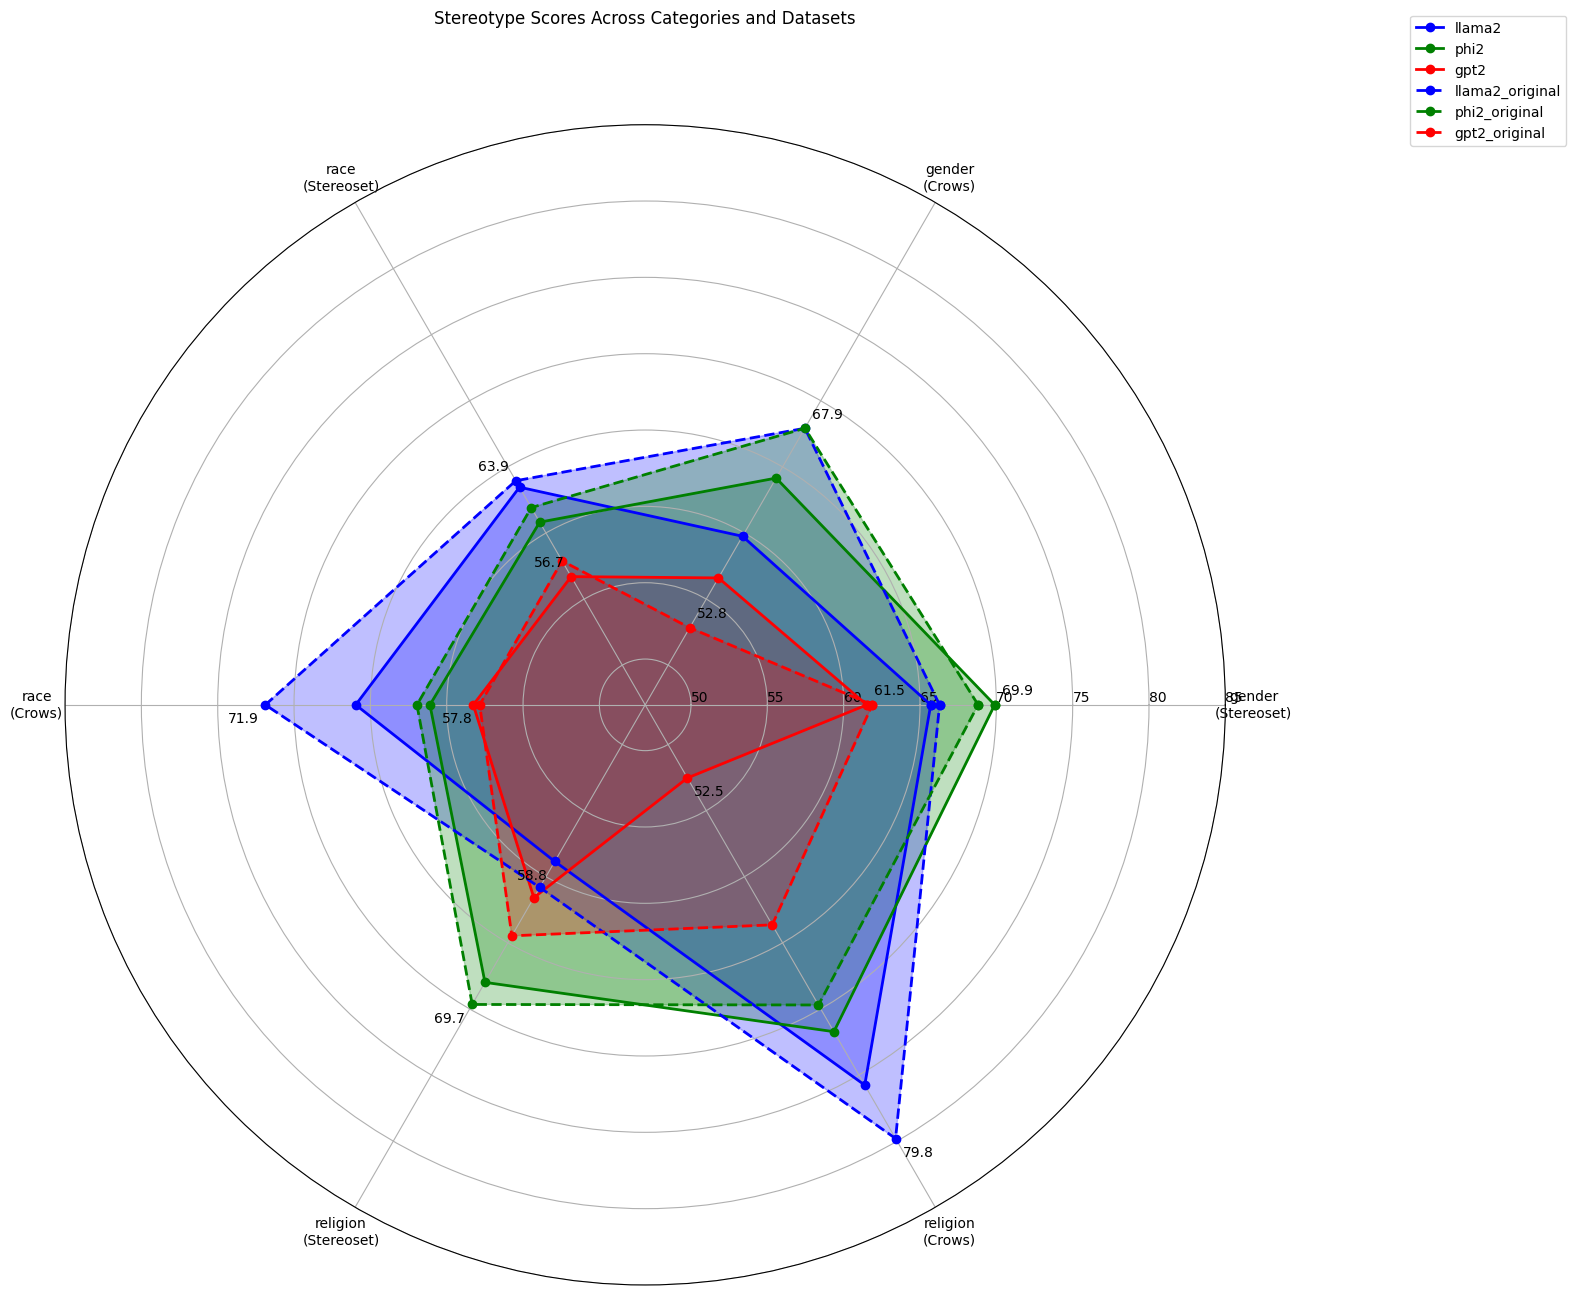

In [28]:
all_models_category_radar_chart(crows_data, stereoset_data)

# Bar chart instead

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def model_comparison_bar_chart(crows_data, stereoset_data):
    categories = ['gender', 'race', 'religion']
    models = ['llama2', 'phi2', 'gpt2']
    datasets = ['Stereoset', 'Crows']

    fig, axs = plt.subplots(2, 1, figsize=(18, 24), height_ratios=[3, 1])
    ax = axs[0]

    x = np.arange(len(categories))
    width = 0.08  # Reduced width
    group_width = width * len(models) * 2 * len(datasets)

    colors = plt.cm.Set3(np.linspace(0, 1, len(models) * len(datasets)))

    legend_elements = []

    for i, dataset in enumerate(datasets):
        for j, model in enumerate(models):
            original_values = []
            debiased_values = []

            for cat in categories:
                if dataset == 'Stereoset':
                    original_values.append(stereoset_data[f"{model}_original"][cat]['SS Score'])
                    debiased_values.append(stereoset_data[model][cat]['SS Score'])
                else:  # Crows
                    cat_key = cat if cat != 'race' else 'race-color'
                    original_values.append(crows_data[f"{model}_original"][cat_key]['Stereotype score'])
                    debiased_values.append(crows_data[model][cat_key]['Stereotype score'])
                    


            offset = width * (i * len(models) * 2 + j * 2) - group_width / 2
            color = colors[i * len(models) + j]

            rects1 = ax.bar(x + offset, original_values, width, color=color, alpha=0.7, edgecolor='black', label=f'{model} ({dataset}) - Original')
            rects2 = ax.bar(x + offset + width, debiased_values, width, color=color, alpha=1, edgecolor='black', hatch='//', label=f'{model} ({dataset}) - Debiased')

            ax.bar_label(rects1, padding=3, rotation=90, fmt='%.1f', fontsize=8)
            ax.bar_label(rects2, padding=3, rotation=90, fmt='%.1f', fontsize=8)

            legend_elements.append(Patch(facecolor=color, edgecolor='black', alpha=0.7, label=f'{model} ({dataset}) - Original'))
            legend_elements.append(Patch(facecolor=color, edgecolor='black', alpha=1, hatch='//', label=f'{model} ({dataset}) - Debiased'))

    ax.set_ylabel('Stereotype Score')
    ax.set_title('Stereotype Scores Comparison: Original vs Debiased Models')
    ax.set_xticks(x, categories)
    ax.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3)
    ax.set_ylim(0, 100)

    plt.setp(ax.get_xticklabels(), rotation=0, ha='center')

    # Add a table with the exact values
    cell_text = []
    cell_colors = []
    for dataset in datasets:
        for model in models:
            row = [f"{model} ({dataset})"]
            row_colors = ['white']
            for cat in categories:
                if dataset == 'Stereoset':
                    cat_key = cat if cat != 'race' else 'race-color'
                    original = stereoset_data[f"{model}_original"][cat]['SS Score']
                    debiased = stereoset_data[model][cat]['SS Score']
                else:  # Crows
                    cat_key = cat if cat != 'race' else 'race-color'
                    original = crows_data[f"{model}_original"][cat_key]['Stereotype score']
                    debiased = crows_data[model][cat_key]['Stereotype score']
                row.append(f"{original:.1f} → {debiased:.1f}")
                row_colors.append('white')
            cell_text.append(row)
            cell_colors.append(row_colors)

    # Find and highlight the lowest score for each category
    for col in range(1, len(categories) + 1):
        min_value = float('inf')
        min_indices = []
        for row in range(len(cell_text)):
            value = float(cell_text[row][col].split('→')[1].strip())
            if value < min_value:
                min_value = value
                min_indices = [row]
            elif value == min_value:
                min_indices.append(row)
        for row in min_indices:
            cell_colors[row][col] = 'lightgreen'

    table = axs[1].table(cellText=cell_text, colLabels=['Model'] + categories,
                         cellLoc='center', loc='center', cellColours=cell_colors)
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    axs[1].axis('off')

    plt.tight_layout()
    plt.savefig('media/dropout/model_comparison_bar_chart.png', bbox_inches='tight', dpi=300)
    plt.show()

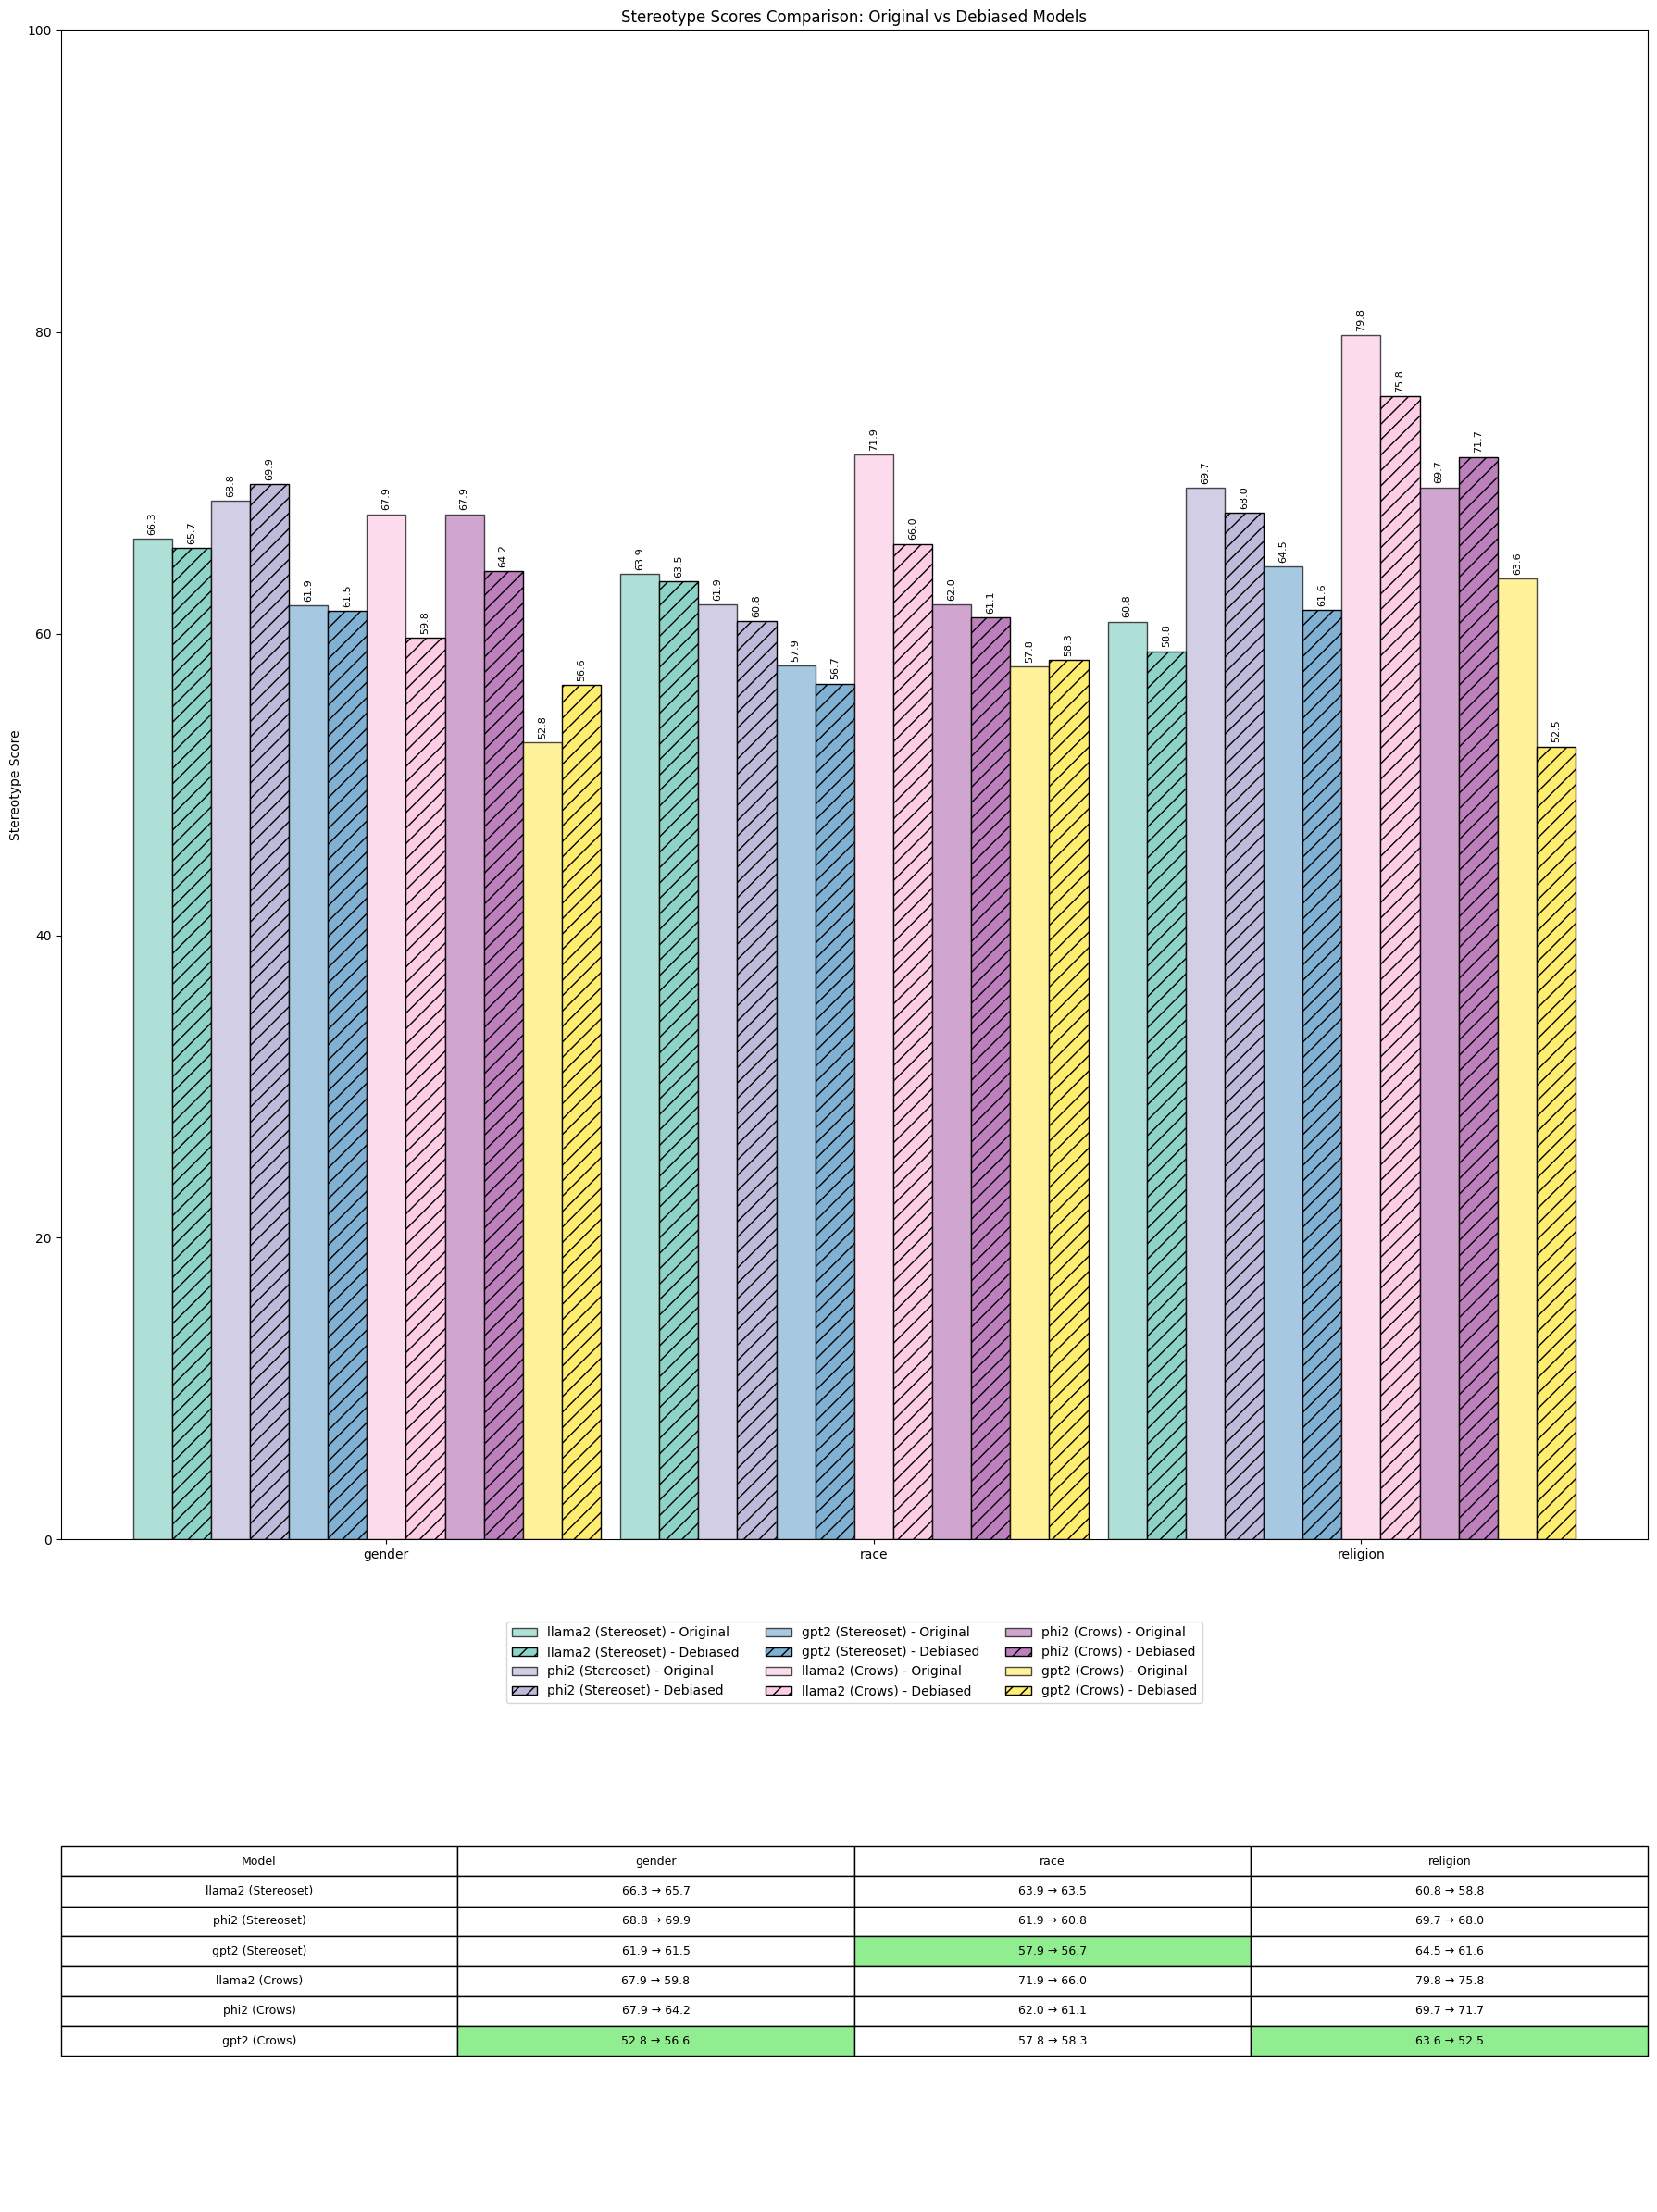

In [30]:
model_comparison_bar_chart(crows_data, stereoset_data)